<a href="https://colab.research.google.com/github/madch3m/Federated-learning-ml-graph/blob/experimental_rd/federated_learning_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-utils


  Preparing metadata (setup.py) ... done
  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6188 sha256=ccdfa78ee7dc8d0e252151f2a0d4e0b8003af3977b7a9664552f629dd257d974
  Stored in directory: /root/.cache/pip/wheels/4e/06/32/1d26da91e30177d171ecb60995273ad8709ca2b6ce66ccefa7
Successfully built torch-utils


Hyperparams for the federated graph

In [46]:
import random
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Tuple

@dataclass
class HParams:
  num_clients: int = 10
  smple_clients: float = 0.5
  local_epochs: int = 5
  local_batch_size: int = 64
  lr: float = 0.01
  momentum: float = 0.0
  seed: int = 42
  iid: bool = True
  device: str = 'cpu'

Convolutional Neural Net

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from typing import List, Tuple

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(32,64,3,padding=1), nn.ReLU(),nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
        nn.Linear(128,10)
    )
  def forward(self, x):
      return self.net(x)



Data loading and splitting for clients

In [43]:
def load_data() -> Tuple[List[Subset], torch.utils.data.Dataset]:
    transform = transforms.Compose([transforms.ToTensor()])
    train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if hp.iid:
        sizes = [len(train) // hp.num_clients] * hp.num_clients

        sizes[-1] += len(train) - sum(sizes)
        shards = random_split(train, sizes, generator=torch.Generator().manual_seed(hp.seed))
        clients = [Subset(train, s.indices) for s in shards]
        return clients, test

    else:
        targets = train.targets
        sorted_idx = targets.sort()[1].tolist()
        sorted_ds = Subset(train, sorted_idx)
        sizes = [len(sorted_ds) // hp.num_clients] * hp.num_clients
        sizes[-1] += len(sorted_ds) - sum(sizes)
        shards = []
        start = 0
        for size in sizes:
            idxs = list(range(start, start + size))
            shards.append(Subset(sorted_ds, idxs))
            start += size
        return shards, test



Client Logic

In [27]:
def client_update(global_model: nn.Module, dataset: Subset) -> Tuple[Dict[str, torch.Tensor], int]:
    model = deepcopy(global_model).to(hp.device)
    model.train()
    loader = DataLoader(dataset, batch_size=hp.local_batch_size, shuffle=True, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=hp.lr, momentum=hp.momentum)

    for _ in range(hp.local_epochs):
        for x, y in loader:
            x, y = x.to(hp.device), y.to(hp.device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    return deepcopy(model.state_dict()), len(dataset)

Aggregation Logic

In [28]:
@torch.no_grad()
def fedavg(global_model: nn.Module, client_states: List[Tuple[Dict[str,torch.Tensor],int]]):
    total_samples = sum(n for _, n in client_states)

    avg_state = {k: torch.zeros_like(v, device=hp.device) for k, v in global_model.state_dict().items()}

    for state_dict, n in client_states:
        weight = n / total_samples
        for k in avg_state.keys():
          avg_state[k] += state_dict[k].to(hp.device) * weight
    global_model.load_state_dict(avg_state)

In [29]:
@torch.no_grad()
def evaluate(model: nn.Module, testset) -> Tuple[float,float]:
    model.eval().to(hp.device)
    loader = DataLoader(testset, batch_size=512, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    correct, total, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(hp.device), y.to(hp.device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


Orchestrator

In [48]:
import matplotlib.pyplot as plt
import time, random, torch

def orchestrate(model_name):
    random.seed(hp.seed)
    torch.manual_seed(hp.seed)

    clients, testset = load_data()
    global_model = CNN().to(hp.device)

    acc_history = []   # for plotting accuracy
    loss_history = []  # for plotting loss
    rounds_history = []   # for plotting rounds on the x-axis

    TIMEOUT_MAX = 10 * 60 # 10-minute timeout
    TARGET_ACC = 0.90
    start_time = time.perf_counter()
    rounds_run = 0

    print(f"\nStarting federated training: Target Accuracy={TARGET_ACC*100:.2f}% | Timeout={TIMEOUT_MAX} seconds")
    print(f"\tClients={hp.num_clients}, Sample Clients={hp.smple_clients}, "
          f"Local Epochs={hp.local_epochs}, Batch={hp.local_batch_size}, "
          f"Learning Rate={hp.lr}, Momentum={hp.momentum}, "
          f"iid={hp.iid}\n")
    while True:
        elapsed = time.perf_counter() - start_time
        if elapsed >= TIMEOUT_MAX:
            print("\tTimeout hit. Stopping.")
            break

        rounds_run += 1
        m = max(1, int(hp.smple_clients * hp.num_clients))
        selected = random.sample(range(hp.num_clients), m)

        client_states = []
        for cid in selected:
            state, n_samples = client_update(global_model, clients[cid])
            client_states.append((state, n_samples))

        fedavg(global_model, client_states)

        acc, los = evaluate(global_model, testset)

        acc_history.append(acc)
        loss_history.append(los)
        rounds_history.append(rounds_run)

        print(f"\tRound {rounds_run:02d} | acc={acc*100:.2f}% | loss={los:.4f} | elapsed={time.perf_counter() - start_time} seconds")
        if acc >= TARGET_ACC:
            print(f"\tTarget accuracy reached ({acc*100:.2f}%) at round {rounds_run}.")
            break

    torch.save(global_model.state_dict(), model_name)
    print(f"\tModel saved: {model_name}")

    # Plot metrics
    plt.figure(figsize=(10,4)) # (width, height) of the plot
    plt.subplot(1,2,1) # (number of rows, number of columns, plot index)
    plt.plot(rounds_history, [a*100 for a in acc_history], 'o-', label='Accuracy (%)')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Communication Rounds')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rounds_history, loss_history, 'o-', color='orange', label='Loss')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Loss')
    plt.title('Loss vs Communication Rounds')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig("federated_training_progress.png")


Starting federated training: target_acc=90.00% | timeout=360 seconds
	Clients=10, sample_frac=0.5, local_epochs=2, batch=64, learning_rate=0.01, momentum=0.0, iid=False

	Round 01 | acc=18.75% | loss=2.4366 | elapsed=108.27507873200011 seconds
	Round 02 | acc=11.87% | loss=2.9209 | elapsed=206.22276088699982 seconds
	Round 03 | acc=11.35% | loss=2.5935 | elapsed=303.84810742599984 seconds
	Round 04 | acc=25.64% | loss=2.1889 | elapsed=402.9860080850003 seconds
	Timeout hit. Stopping.
	Model saved


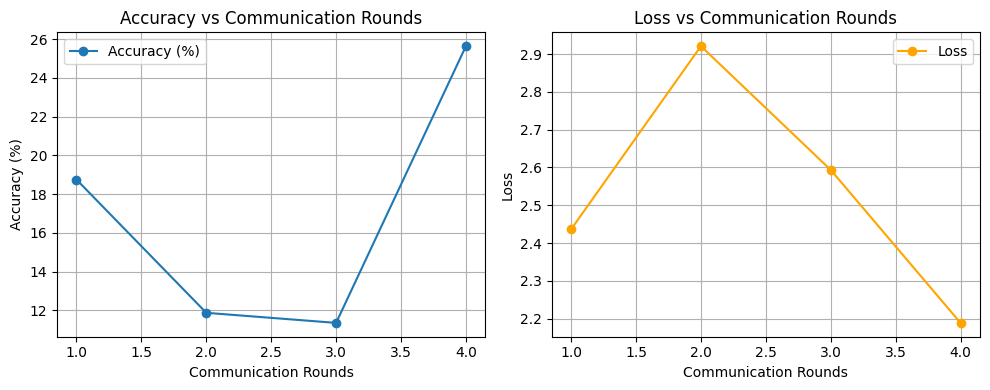

Starting federated training: target_acc=90.00% | timeout=360 seconds
	Clients=10, sample_frac=0.5, local_epochs=2, batch=64, learning_rate=0.01, momentum=0.0, iid=True

	Round 01 | acc=61.45% | loss=2.2013 | elapsed=97.92498789100046 seconds
	Round 02 | acc=77.75% | loss=1.0249 | elapsed=198.17004812600044 seconds
	Round 03 | acc=87.16% | loss=0.4723 | elapsed=298.66096371500043 seconds
	Round 04 | acc=88.50% | loss=0.3860 | elapsed=398.6490936609998 seconds
	Timeout hit. Stopping.
	Model saved


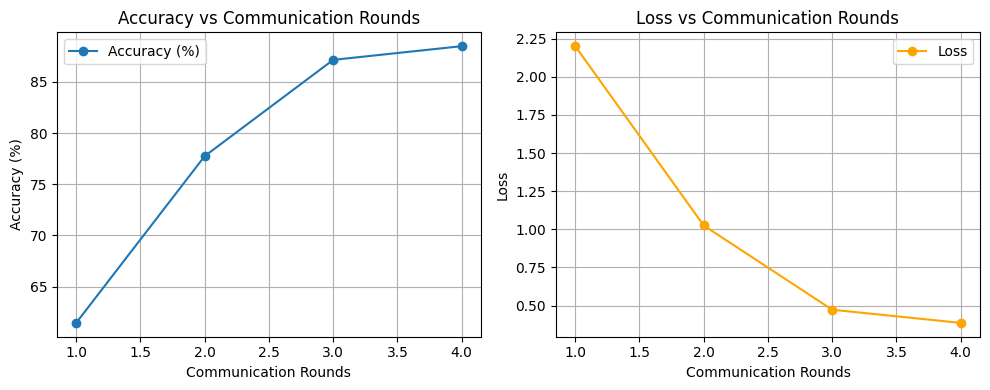

In [45]:
hp = HParams(iid=False)
orchestrate("FedAvg_Mnist_Cnn_Noniid.pt")

hp = HParams(iid=True)
orchestrate("FedAvg_Mnist_Cnn_iid.pt")